# E10 - Camera sticker app

위치를 찾아내는 기술: 랜드마크, 조정, keypoint detection(더 큰 범위로)

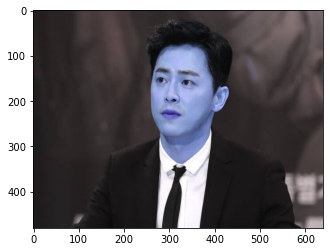

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()


# cv2는 색공간을 BGR(파녹빨)을 사용하기 때문에 피부색이 파랐다.
# 다른 이미지 라이브러리에서 사용하려면 색보정을 해줘야 한다.

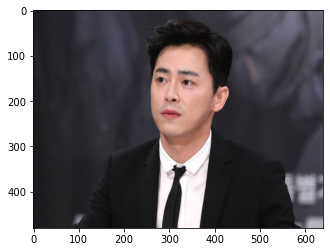

In [9]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# openCV: https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html

In [10]:
# 이미지의 패턴을 알기 위해 hog 사용
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

# detector를 이용하여 이미지의 bounding box 추출하기
# dlib은 rgb 사용한다. 변환필요
# detector_hog의 두 번째 파라미터는 이미지 피라미드의 수
# 이미지 피라미드: 이미지를 upsampling방법을 통해 크기를 키우는 것
# 작게 촬영된 이미지를 크게 볼 수 있기 때문에 더 정확한 검출 가능
# https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(236, 98) (390, 253)]]


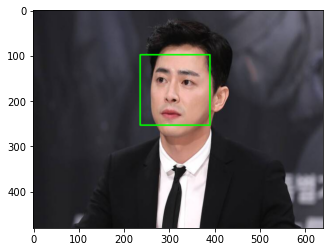

In [11]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

face landmark localization: 이목구비의 위치를 추론하는 것   
object keypoint estimation: face landmark와 같이 객체 내부의 점을 찾는 기술   
keypoint 찾는 알고리즘은 두 가지가 있다.
1. top-down: bounding box를 찾고 box내부의 keypoint 예측
2. bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용, 군집화해서 box생성   
dlib은 미리 학습된 모델 제공(regression tree의 앙상블 모델 사용)

wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2   
mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models   
cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2   

In [13]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    # landmark_predictor는 이미지와 bounding box를 받는다.
    points = landmark_predictor(img_rgb, dlib_rect)
    # points는 dlib.full_object_detection 객체
    # parts()함수로 개별 위치로 접근 가능하게 하기 위해 (x, y)형태로 변환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


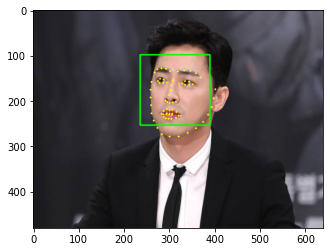

In [14]:
# 랜드마크 출력

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [15]:
# 코 위치에서 떨어진 거리, 눈썹 위치에 떨어진 픽셀 계산
# 얼굴위치, 카메라의 거리에 따라 픽셀이 다르기 때문에 비율 계산
# 1. 스티커 위치
# x = x(nose)
# y = y(nose) - width/2
# 2. 스티커 크기: width = height = width(bbox)

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 코의 중심점 위치

(300, 187)
(x,y) : (300,110)
(w,h) : (155,155)


In [16]:
# 스티커 이미지 읽어서 resize하기

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(155, 155, 3)


In [17]:
# 원본 이미지에 스티커 이미지 추가하기, 스티커 좌표조정

refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표 음수는 원본 이미지 밖으로 나갔다.
# opencv 데이터는 numpy ndarray 형태의 데이터이므로 음수 인덱스 접근 안됨

(x,y) : (223,-45)


In [18]:
# 원본 이미지에 나간 부분은 짤라내기
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(110, 155, 3)


In [19]:
# top좌표 수정
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (223,0)


In [20]:
# 원본 이미지에 스티커 적용

# sticker_area: 원본이미지에 스티커를 적용할 위치을 crop
# 스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분 사용
# np.where()에서 img_sticker가 0인 부분은 sticker_area사용, 아닌 부분은 img_sticker사용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

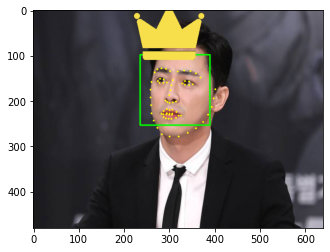

In [21]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

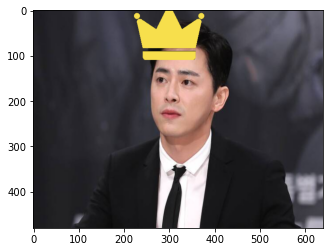

In [22]:
# bounding box, landmark 제거

sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()